# Résolution de l'EDP de Burgers

On souhaite résoudre l’EDP de Burgers paramétrique visqueuse déterminée par la formule suivante:

$$
\partial_t u + \partial_x \left( \frac{u^2}{2} \right) - \epsilon \partial_{xx} u = 0, \quad x \in [0, 1]
$$

Avec les conditions initiales et aux bords:

$$
 u(0, x) = u_0(x), \quad x \in [-1, 1]
$$
$$
 u(t, -1) = u(t, 1) = 0, \quad t > 0
$$

Où $\epsilon \in [0.02, 0.2]$ est le coefficient de viscosité.

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim


In [3]:
class Mesh:
    def __init__(self, a, b, N):
        self.a = a
        self.b = b
        self.N = N
        self.dx = (b-a)/N
        self.centers = np.linspace(a + self.dx/2, b - self.dx/2, N)
        self.interfaces = np.linspace(a, b, N+1)


In [4]:
#Phyical
epsilon = np.random.uniform(0.02,0.20)
#Domain 
a = 0
b = 1
N = 400
dx = (b - a) / N
mesh = Mesh(a,b,N)

## Time
T = 0.2
lambda_ = 1.2 # for sinus 
dt =  min(0.5*dx**2/ epsilon, dx/lambda_) *0.5
nSteps = int(T/dt)


def u0(x):
    return np.exp(-100*(x-0.5)**2)


#initiation
u = u0(mesh.centers)
resultMatrix = np.zeros([N,nSteps])
resultMatrix[:,0] = u

for i in range(1,nSteps):
    #numerique scheme base on project with Carl
    Ur = 0
    Ul = 0

    un = u.copy()   
    coeff= epsilon + dx/2*lambda_
    u[1:-1] = un[1:-1] -   0.25*dt / dx *(un[2:]**2 - un[:-2]**2) + coeff * dt / dx**2 *(un[2:] - 2 * un[1:-1] + un[:-2])

    # à droite de u[-1] on rajoute 0
    u[-1] = un[-1] -   0.25*dt / dx *(Ur**2 - un[-2]**2) + coeff * dt / dx**2 *(Ur - 2 * un[-1] + un[-2])
            
    #a gauche de u[0] on rajoute 0 
    u[0] = un[0] -   0.25*dt / dx *(un[2]**2 - Ul**2) + coeff * dt / dx**2 *(un[2] - 2 * un[1] +Ul)

    resultMatrix[:, i] = u

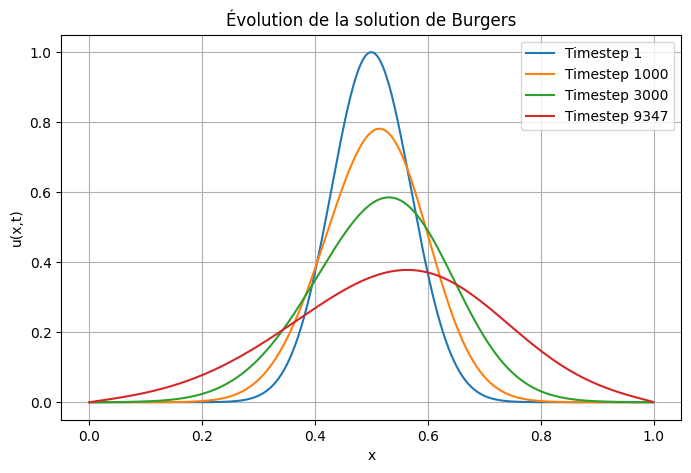

In [5]:
# Affichage des résultats
plt.figure(figsize=(8, 5))
time_steps = [1, 1000, 3000, nSteps - 1]
for t in time_steps:
    plt.plot(mesh.centers, resultMatrix[:, t], label=f'Timestep {t}')

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Évolution de la solution de Burgers')
plt.legend()
plt.grid()
plt.show()

In [7]:
target = torch.tensor(resultMatrix)
X_train = torch.tensor(mesh.centers)
T_train = torch.tensor(np.linspace(0.2,nSteps))


class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers1 = nn.Linear(1, 50)
        self.layers2 =    nn.Linear(50, 50)
        self.layers3 =    nn.Linear(50, 50)
        self.layersf=    nn.Linear(50, 1)
        
    
    def forward(self, x):
        a = torch.tanh(self.layers1(x))
        b = torch.tanh(self.layers2(b))
        c = torch.tanh(self.layers3(b))
        return self.layersf(c)


# Initialisation du modèle
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)



def u_PINN(x, t):
    u = model(torch.stack([x, t]).transpose(0, 1))
    return u


def loss_function(t, x,eps):
    u = u_PINN(x, t)[0]
    u = model(x)
    
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
    f = u_t + u * u_x - eps * u_xx
    
    loss = torch.mean(f**2)
    return loss 


def optimize(epochs=20000, track=True):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0003)
    for i in range(epochs):
        optimizer.zero_grad()
        output = u_PINN(X_train, T_train).view(1,-1).squeeze(0)
        MSE_u = criterion(output, target)
        MSE_f = torch.mean(F()**2)
        loss = MSE_u + MSE_f
        l, u, f = loss.item(), MSE_u.item(), MSE_f.item()
        if track:
            print("MSE: %.6f | MSE_u: %.6f | MSE_f: %.6f" % (l, u, f))
            #print(loss)
        loss.backward()
        optimizer.step()
        

def train(mesh,model, optimizer, epochs=1000):
    t = torch.tensor(0.2)
    x = torch.tensor(mesh.centers)
    for epoch in range(epochs):
        optimizer.zero_grad()
        x = torch.tensor(mesh.centers)
        
        loss = loss_function(t, x, epsilon)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Entraînement
train(mesh,model, optimizer)

RuntimeError: stack expects each tensor to be equal size, but got [400] at entry 0 and [] at entry 1